In [2]:
import os 
import numpy as np
from tqdm.auto import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
pip install thop

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install segmentation_models_pytorch

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from torch import nn
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from torch.autograd import detect_anomaly
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from thop import profile
import kagglehub

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-27 16:17:44.483447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751041064.505052     179 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041064.511642     179 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
torch.backends.cudnn.benchmark=True  # speeind~#g up training for fixed input size
torch.backends.cudnn.deterministic = False # trading off some randomness for speed

Path to dataset files: /kaggle/input/satellite-images-of-water-bodies
image mpode: RGB


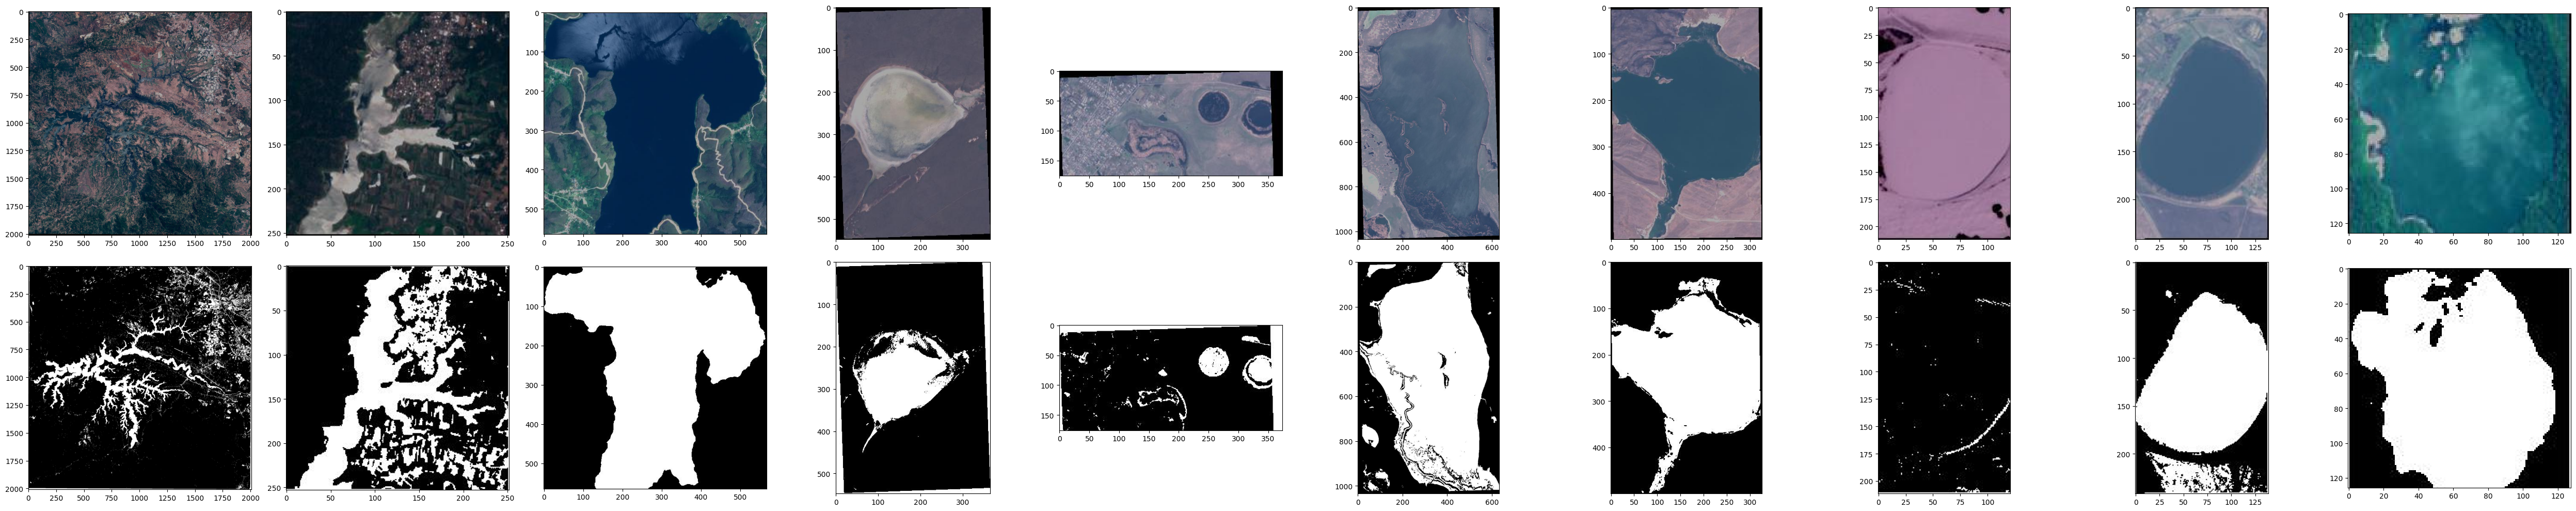

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

print("Path to dataset files:", path)

img_folder = path+"/Water Bodies Dataset/Images"
mask_folder = path+"/Water Bodies Dataset/Masks"

images_name = sorted(os.listdir(img_folder))
masks_name = sorted(os.listdir(mask_folder))

image_files_list  = [os.path.join(img_folder,img_name) for img_name in images_name]
mask_files_list  = [os.path.join(mask_folder,mask_name) for mask_name in masks_name]

#checking the images mode
img = Image.open(image_files_list[15])
print ( 'image mpode:', img.mode)

## plotting some of the images
fig,axs = plt.subplots(2,10, figsize= (50,10))
ax = axs.flatten()
for i in range(0,10):
    ax[i].imshow(np.array(Image.open(image_files_list[i]).convert('RGB')))
    ax[i+10].imshow(np.array(Image.open(mask_files_list[i])))
    
plt.tight_layout()
plt.show()




In [8]:
#creating data class

class WaterDataset(Dataset):
    def __init__ (self, img_list, mask_list, transform= None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path, mask_path  = self.img_list[idx] , self.mask_list[idx]

        img = np.array(Image.open(image_path),dtype=np.float32)
        img = img/255.0 

        mask = np.array(Image.open(mask_path).convert('L'),dtype=np.float32)
        mask = mask/255.0
        
        # print(img.shape, mask.shape)
        if self.transform :
            transformed  = self.transform(image=img,mask = mask)
            img = transformed['image']
            mask = torch.round(transformed['mask'])

        else:
            
            img , mask = torch.tensor(img).permute(2,0,1),torch.round(torch.tensor(mask))
            img = torchvision.transforms.functional.normalize(img,(0.5,0.5,0.5),(0.5,0.5,0.5))
        
        mask=mask.unsqueeze(0)
        return img, mask


            

In [9]:
transform= A.Compose([
    # resizing to (256*1.05 = 282) *282 image and apply centre crop to 256 for removing the unwanted edges
    A.Resize(282,282,1.0),
    A.CenterCrop(height=256,width=256,p=1.0),

    # applying random horiztonal flipping 
    A.HorizontalFlip(p=0.5),
    
    # other approaches for creating synthetic data 
    # transforms.ColorJitter(brightness=0.2,contrast=0.2),
    # transforms.RandomAffine(degrees=15, scale=(0.95,1.05), translate=(0.05,0.05)),

    # A.normalize input is (height,width,3) for RGB and (height,width,1) for greyscale
    # different from torchvision.transforms.functional.noramlize()
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.ToTensorV2()
    
])

In [10]:
X_train , X_val , y_train, y_val = train_test_split(image_files_list, mask_files_list,test_size = 0.1 , random_state=42)

In [11]:
train_dataset = WaterDataset (X_train,y_train,transform=transform)
test_dataset = WaterDataset (X_val,y_val,transform = transform)

train_loader = DataLoader(train_dataset,batch_size= 32 , num_workers = 4 , shuffle = True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 32 , num_workers =4 , shuffle = True, pin_memory=True)


In [12]:
# checking the shapes of the tensors
check_img , check_mask = train_dataset[2]
## check_img , check_mask = train_dataset[2]
check_img.shape, check_mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [19]:
model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b3',
    encoder_weights='advprop',
    in_channels=3,
    classes=1,
    activation=None) #activation set to none for logits output
# checking the summary of the 
# print(model)
# summary(model,(3,256,256))

config.json:   0%|          | 0.00/94.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [20]:
dummy_input = torch.rand(1,3,256,256)
flops, params = profile(model, inputs=(dummy_input,))
gflops = flops / 1e9

print(f"FLOPs: {flops:,}")
print(f"GFLOPs: {gflops:.3f}")
print(f"Parameters: {params:,}")

[INFO] Register zero_ops() for <class 'torch.nn.modules.padding.ZeroPad2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
FLOPs: 6,569,934,848.0
GFLOPs: 6.570
Parameters: 3,012,785.0


In [18]:
model(dummy_input).shape

torch.Size([1, 1, 256, 256])

In [19]:
# list(model.encoder.parameters())

In [17]:
# Using the sum of DiceLoss and BCELoss as the Loss function

#dice_loss
def dice_loss (pred,target,epsilon=1e-6):

    pred = torch.sigmoid(pred)
       
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)
    return 1 - dice

#Creating combinedLoss 
class CombinedLoss(nn.Module):
    def __init__(self,bce_weight=0.6,beta=0.7):
        super().__init__()

        self.bce_loss= nn.BCEWithLogitsLoss()
        # self.bce_loss= nn.BCELoss()

        self.bce_weight = bce_weight
    
    def forward(self,logits,targets,return_individual=True):
        
        dice = dice_loss(logits,targets)
        
        bce = self.bce_loss(logits,targets)
        # iou = jaccard_loss(logits,targets)
        combined = (1-self.bce_weight)*dice + (self.bce_weight)*bce

        if return_individual:
            return combined, dice, bce
        return combined

In [15]:
def plot_sample_images(images,masks,model,epoch):
    fig, axes = plt.subplots(1, 3, figsize=(5, 3))
    # fig.suptitle(f'Epoch {epoch + 1} - Detailed Predictions', fontsize=16)
    
    ax=axes.flatten()
    img_np = images[3].cpu().permute(1,2,0)
    img_for_plot_np = images[3].cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    img_np = img_np * std + mean
    
    mask_np = masks[3].cpu().permute(1,2,0)
    
    with torch.no_grad():
        logits = model(images[3].unsqueeze(0))
        prediction = torch.sigmoid(logits[0])
        #setting threshold as 0.5
        prediction=(prediction > 0.5)*1.0
    
    
    ax[0].imshow(img_np*255.0)
    ax[1].imshow(mask_np*255.0, cmap='gray')
    ax[2].imshow(prediction.permute(1,2,0).cpu().numpy()*255.0)

    plt.tight_layout()
    plt.show()

In [16]:
## Training Function
def train(model, train_loader, val_loader, optimizer, criterion, epochs,scheduler=None):
    train_losses, val_losses = [], []
    train_dice_losses, val_dice_losses = [], []
    train_bce_losses, val_bce_losses = [], []
    
    writer = SummaryWriter()
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in tqdm(range(epochs),desc="Epoch",position=0, leave=True):
        
        model.train()
        # resetting the loss for each full batch propagations
        total_training_loss ,total_training_dice ,total_training_bce = 0.0 , 0.0 , 0.0
        
        for  images, masks in tqdm(train_loader,desc="training_batch",position=1, leave=True):
            
            images , masks = images.to(device) , masks.to(device)        

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                output = model(images)
                total_loss, dice_component, bce_component = criterion(output, masks, return_individual=True)
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ### added to check if there is any nan or exploding gradient
            # with detect_anomaly():
            # logits = model(images)
            # loss  = criterion(logits,masks)
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            
            total_training_loss += total_loss.item()
            total_training_dice += dice_component.item()
            total_training_bce += bce_component.item()
            
        if epoch %3 ==0:
            plot_sample_images(images,masks,model,epoch)
                      
        # gradient flow and check for vanishing gradient  
        # if epoch <2:
        #     plot_grad_flow(model.named_parameters())  
        
        # Calculate and append training loss each epoch
        train_loss_this_epoch = total_training_loss / len(train_loader)
        train_dice_this_epoch = total_training_dice / len(train_loader)
        train_bce_this_epoch = total_training_bce / len(train_loader)
        
        train_losses.append(train_loss_this_epoch)
        train_dice_losses.append(train_dice_this_epoch)
        train_bce_losses.append(train_bce_this_epoch)
        # writer.add_scalar("Loss/train", train_loss_this_epoch, epoch)

        if scheduler is not None:
            scheduler.step()
        
        model.eval()
        total_val_loss, total_val_dice, total_val_bce  = 0.0 , 0.0, 0.0
        
        with torch.no_grad():
            for images,masks in tqdm(val_loader,desc="val_batch",position=2, leave=True):
                images, masks = images.to(device) , masks.to(device)
                
                logits = model(images)
                total_loss, dice_component, bce_component = criterion(logits, masks, return_individual=True)
                
                total_val_loss += total_loss.item()
                total_val_dice += dice_component.item()
                total_val_bce += bce_component.item()
                
        if epoch %3 ==0:
            plot_sample_images(images,masks,model,epoch)
        
        val_loss_this_epoch = total_val_loss / len(val_loader)
        val_dice_this_epoch = total_val_dice / len(val_loader)
        val_bce_this_epoch = total_val_bce / len(val_loader)
        
        val_losses.append(val_loss_this_epoch)
        val_dice_losses.append(val_dice_this_epoch)
        val_bce_losses.append(val_bce_this_epoch)

        
        # writer.add_scalar("Loss/test", val_loss_this_epoch, epoch)

        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'  Train - Total: {train_loss_this_epoch:.4f}, Dice: {train_dice_this_epoch:.4f}, BCE: {train_bce_this_epoch:.4f}')
        print(f'  Val   - Total: {val_loss_this_epoch:.4f}, Dice: {val_dice_this_epoch:.4f}, BCE: {val_bce_this_epoch:.4f}')
        print('-' * 80)
        
    # writer.close()
        
    return [train_losses , train_dice_losses,train_bce_losses], [val_losses ,val_dice_losses,val_bce_losses]

In [24]:
#https://pmc.ncbi.nlm.nih.gov/articles/PMC9789743/
# https://arxiv.org/pdf/1905.11946

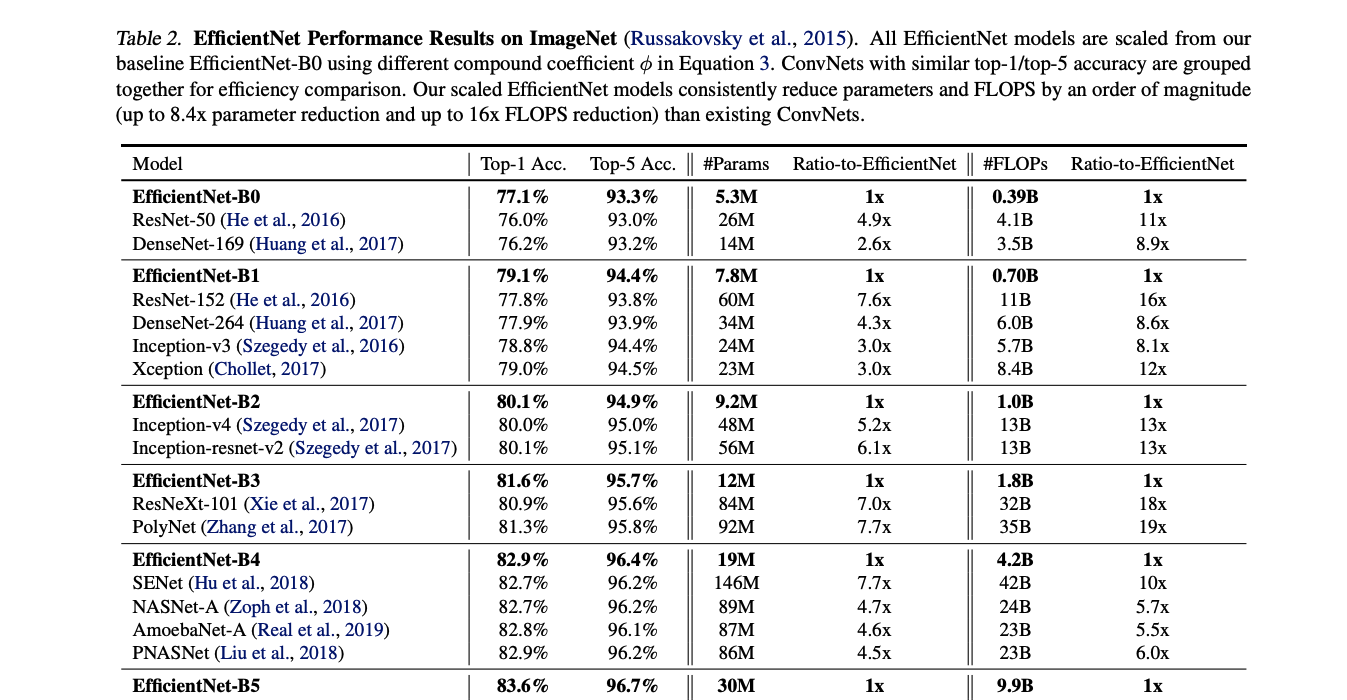
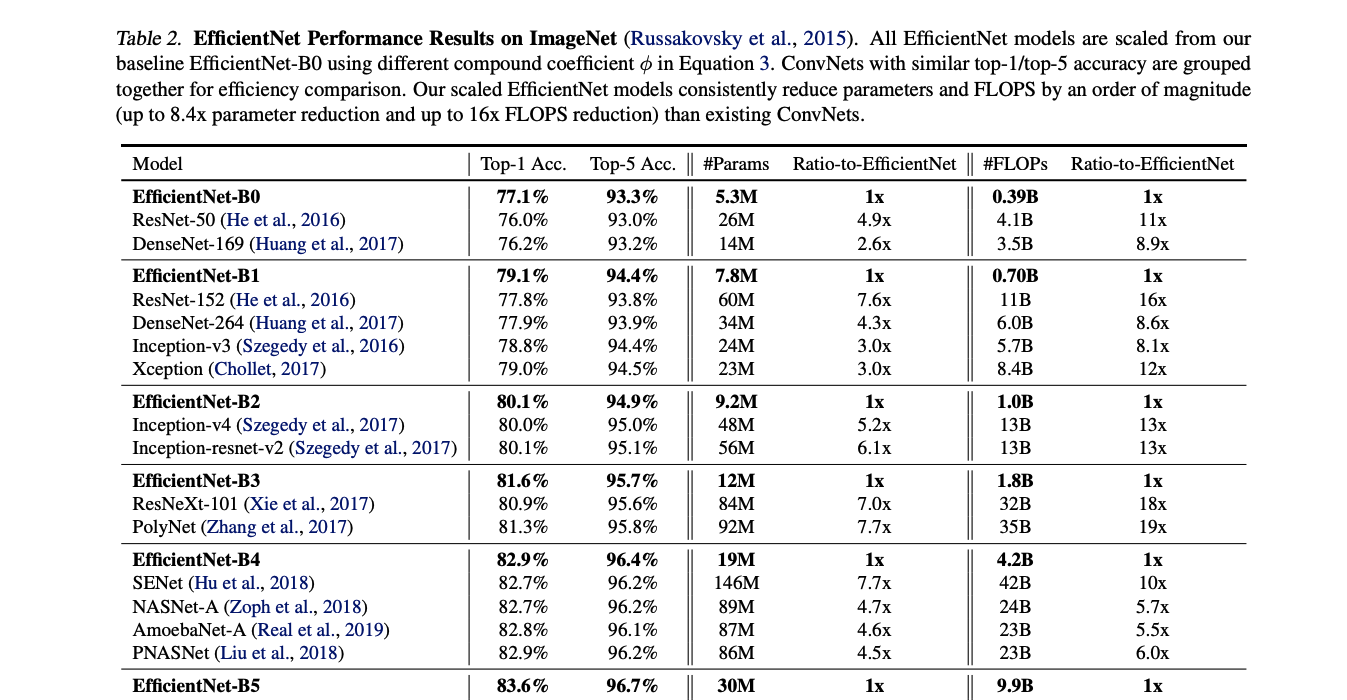

In [21]:
model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b3', #'densenet169', #efficientnet-b3
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
    activation=None) #activation set to none for logits output


# freezing all layers except the final one
for param in model.parameters():
    param.requires_grad = False

for param in model.decoder.parameters():
    param.requires_grad = True
    
for param in model.segmentation_head.parameters():
    param.requires_grad = True
    
# model = nn.DataParallel(model)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

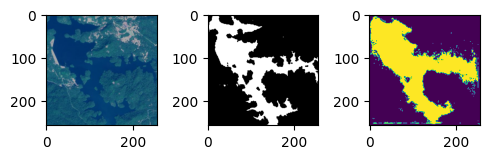

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

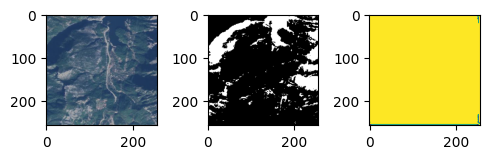

Epoch: 1/15
  Train - Total: 0.4444, Dice: 0.4123, BCE: 0.4659
  Val   - Total: 1.5073, Dice: 0.4964, BCE: 2.1812
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/util

Epoch: 2/15
  Train - Total: 0.3043, Dice: 0.2757, BCE: 0.3233
  Val   - Total: 1.6857, Dice: 0.4963, BCE: 2.4787
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3/15
  Train - Total: 0.2769, Dice: 0.2442, BCE: 0.2987
  Val   - Total: 1.3623, Dice: 0.4903, BCE: 1.9437
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

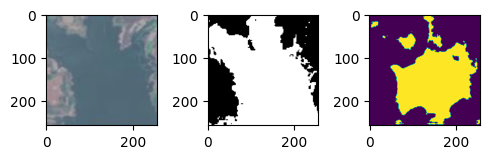

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

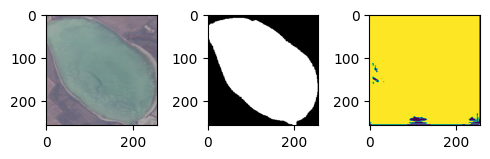

Epoch: 4/15
  Train - Total: 0.2585, Dice: 0.2253, BCE: 0.2806
  Val   - Total: 0.8366, Dice: 0.4469, BCE: 1.0965
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5/15
  Train - Total: 0.2489, Dice: 0.2149, BCE: 0.2716
  Val   - Total: 0.5800, Dice: 0.4259, BCE: 0.6827
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6/15
  Train - Total: 0.2336, Dice: 0.2031, BCE: 0.2539
  Val   - Total: 0.4405, Dice: 0.3750, BCE: 0.4841
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

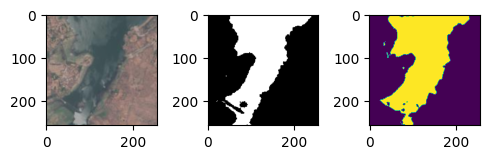

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

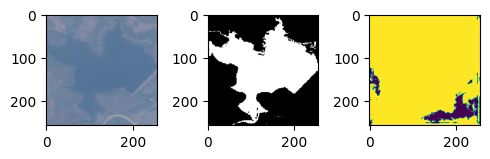

Epoch: 7/15
  Train - Total: 0.2304, Dice: 0.1992, BCE: 0.2512
  Val   - Total: 0.3785, Dice: 0.3292, BCE: 0.4114
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40> 

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
^ ^^^  ^ ^ ^ ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Epoch: 8/15
  Train - Total: 0.2287, Dice: 0.1973, BCE: 0.2497
  Val   - Total: 0.3343, Dice: 0.3012, BCE: 0.3564
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9/15
  Train - Total: 0.2257, Dice: 0.1944, BCE: 0.2467
  Val   - Total: 0.3220, Dice: 0.2801, BCE: 0.3499
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

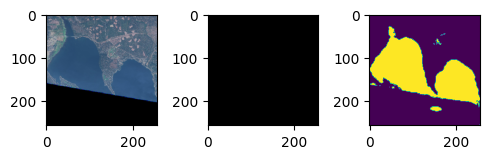

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

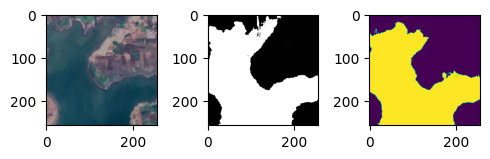

Epoch: 10/15
  Train - Total: 0.2258, Dice: 0.1943, BCE: 0.2467
  Val   - Total: 0.2955, Dice: 0.2558, BCE: 0.3220
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 11/15
  Train - Total: 0.2239, Dice: 0.1927, BCE: 0.2447
  Val   - Total: 0.3007, Dice: 0.2571, BCE: 0.3298
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 12/15
  Train - Total: 0.2267, Dice: 0.1944, BCE: 0.2482
  Val   - Total: 0.2982, Dice: 0.2494, BCE: 0.3308
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

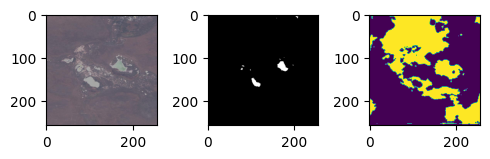

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

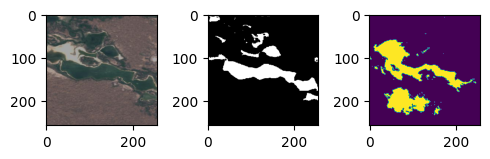

Epoch: 13/15
  Train - Total: 0.2263, Dice: 0.1944, BCE: 0.2475
  Val   - Total: 0.2874, Dice: 0.2342, BCE: 0.3229
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 14/15
  Train - Total: 0.2234, Dice: 0.1925, BCE: 0.2441
  Val   - Total: 0.2871, Dice: 0.2412, BCE: 0.3177
--------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

training_batch:   0%|          | 0/80 [00:01<?, ?it/s]


  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcac3a7c40>
Traceback 

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 15/15
  Train - Total: 0.2216, Dice: 0.1906, BCE: 0.2423
  Val   - Total: 0.2916, Dice: 0.2419, BCE: 0.3248
--------------------------------------------------------------------------------


In [22]:
epochs = 15

# model = nn.DataParallel(model)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
# optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001, weight_decay=1e-3)
# changed from 0.001 as it had shown some slower

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1 )

criterion = CombinedLoss()

train_losses_list, val_losses_list = train(model, train_loader, test_loader, optimizer,criterion,epochs,scheduler)

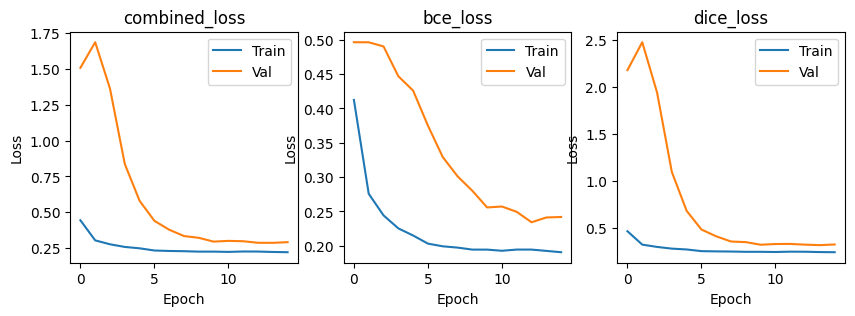

In [25]:
def plot_losses_results(train_losses_list, val_losses_list):
    fig,axs = plt.subplots(1,3,figsize=(10,3))
    ax= axs.flatten()
    i=0
    for train_losses,val_losses, label in zip (train_losses_list, val_losses_list,['combined_loss','bce_loss','dice_loss']):
        ax[i].plot(np.arange(epochs), train_losses)
        ax[i].plot(np.arange(epochs), val_losses)
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel("Loss")
        ax[i].set_title(f'{label}')
        ax[i].legend([f"Train", f"Val"])
        i+=1
    plt.show()
plot_losses_results(train_losses_list, val_losses_list)

In [59]:
torch.cuda.empty_cache()

In [65]:
# modelv3 = smp.DeepLabV3(
#     encoder_name='efficientnet-b3',
#     encoder_weights='imagenet',
#     in_channels=3,
#     classes=1,
#     activation=None)#activation set to none for logits output


# # freezing all layers except the final one
# for param in modelv3.parameters():
#     param.requires_grad = False

# for param in modelv3.decoder.parameters():
#     param.requires_grad = True
    
# for param in modelv3.segmentation_head.parameters():
#     param.requires_grad = True
    
# model = nn.DataParallel(model)

In [69]:
# epochs = 15

# # model = nn.DataParallel(model)
# modelv3.to(device)

# optimizer = torch.optim.AdamW(modelv3.parameters(), lr=0.0001, weight_decay=1e-3)
# # optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001, weight_decay=1e-3)
# # changed from 0.001 as it had shown some slower

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1 )

# criterion = CombinedLoss()

# train_losses_listv3, val_losses_listv3 = train(modelv3, train_loader, test_loader, optimizer,criterion,epochs,scheduler)

# # model = nn.DataParallel(model)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch: 1/15
  Train - Total: 0.4111, Dice: 0.3772, BCE: 0.4338
  Val   - Total: 2.2369, Dice: 0.5193, BCE: 3.3821
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2/15
  Train - Total: 0.3845, Dice: 0.3529, BCE: 0.4056
  Val   - Total: 1.7356, Dice: 0.5211, BCE: 2.5453
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3/15
  Train - Total: 0.3741, Dice: 0.3445, BCE: 0.3938
  Val   - Total: 1.3176, Dice: 0.5209, BCE: 1.8487
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4/15
  Train - Total: 0.3656, Dice: 0.3368, BCE: 0.3848
  Val   - Total: 1.0569, Dice: 0.4974, BCE: 1.4298
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5/15
  Train - Total: 0.3567, Dice: 0.3276, BCE: 0.3762
  Val   - Total: 0.5535, Dice: 0.4379, BCE: 0.6305
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6/15
  Train - Total: 0.3368, Dice: 0.3148, BCE: 0.3515
  Val   - Total: 0.4316, Dice: 0.3865, BCE: 0.4616
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch: 7/15
  Train - Total: 0.3336, Dice: 0.3102, BCE: 0.3492
  Val   - Total: 0.4074, Dice: 0.3626, BCE: 0.4373
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8/15
  Train - Total: 0.3344, Dice: 0.3107, BCE: 0.3501
  Val   - Total: 0.3919, Dice: 0.3468, BCE: 0.4219
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9/15
  Train - Total: 0.3319, Dice: 0.3087, BCE: 0.3473
  Val   - Total: 0.3841, Dice: 0.3425, BCE: 0.4119
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10/15
  Train - Total: 0.3326, Dice: 0.3091, BCE: 0.3482
  Val   - Total: 0.3837, Dice: 0.3387, BCE: 0.4138
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 11/15
  Train - Total: 0.3280, Dice: 0.3048, BCE: 0.3435
  Val   - Total: 0.3844, Dice: 0.3386, BCE: 0.4150
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 12/15
  Train - Total: 0.3282, Dice: 0.3044, BCE: 0.3441
  Val   - Total: 0.3788, Dice: 0.3364, BCE: 0.4071
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7943a79900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 13/15
  Train - Total: 0.3275, Dice: 0.3042, BCE: 0.3431
  Val   - Total: 0.3782, Dice: 0.3388, BCE: 0.4044
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 14/15
  Train - Total: 0.3287, Dice: 0.3052, BCE: 0.3443
  Val   - Total: 0.3814, Dice: 0.3403, BCE: 0.4088
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/80 [00:00<?, ?it/s]

val_batch:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 15/15
  Train - Total: 0.3282, Dice: 0.3053, BCE: 0.3434
  Val   - Total: 0.3800, Dice: 0.3403, BCE: 0.4064
--------------------------------------------------------------------------------


In [24]:
# plot_losses_results(train_losses_listv3, val_losses_listv3)

In [ ]:
torch.cuda.empty_cache()